In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os, subprocess
from itertools import combinations
import scipy
from sklearn.metrics import mean_squared_error

2023-12-30 08:13:06.025017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
sequences = pd.read_csv('../data/enformer_sequences.bed', header=None, sep='\t')
bin_index = [447, 448]
model_name = 'enformer'
seq_length = 196608
outdir = utils.make_dir('../results/train_test_valid/')

In [4]:
# Trivial but horrible
for fold in sequences[3].unique():

    cmd = f'less ../data/enformer_sequences.bed | grep {fold}  > tmp.bed;'
    cmd += f'bedtools sort -i tmp.bed > tmp_s.bed;'
    cmd += f'bedtools merge -i tmp_s.bed > {outdir}/enformer_{fold}_sequences_merged.bed; rm tmp.bed tmp_s.bed'
    
    results = subprocess.run(
        cmd, shell=True)


In [30]:
paths = glob.glob(f'../results/context_dependence_test_100/{model_name}/*pickle')


In [31]:
for path in paths:
    res = utils.read_pickle(path)
    res['mut'][bin_index]

In [33]:
res['mut'][]

(896, 3)

In [ ]:
classified_seq_cell = {}
for cell, cell_context_test_results in context_test_results.groupby('cell_line'):
    print(cell)
    ### expand selected TSS sequences to enformer sequence length and save into => ../results/{cell}_tss_selected.bed
    sequences_with_tss = []
    for file_prefix in tqdm([p.split('/')[-1].split('.')[0] for p in cell_context_test_results['path']]):
        chrom_i, tss_i = file_prefix.split('_')[1:3]
        start_i, end_i = int(tss_i) - seq_length//2, int(tss_i) + seq_length//2
        if start_i >= 0:
            sequences_with_tss.append([chrom_i, start_i, end_i])
    print(len(sequences_with_tss))
    pd.DataFrame(sequences_with_tss).to_csv('tmp.bed', sep='\t', header=None, index=None)
    
    cmd = f'bedtools sort -i tmp.bed > {outdir}/{cell}_tss_selected.bed; rm tmp.bed'
    r = subprocess.run(cmd, shell=True)
    print(r)
    fold_seq_dfs = []
    for fold in sequences[3].unique():
        fold_seqs = []
        cell_fold_bed = f'../results/{cell}_{fold}.bed'
        cmd = f'bedtools intersect -a {outdir}/{cell}_tss_selected.bed -b {outdir}/enformer_{fold}_sequences_merged.bed  -wa -f 1.0 > {cell_fold_bed}'
    
        subprocess.run(
            cmd, shell=True)
        df = pd.read_csv(cell_fold_bed, header=None, sep='\t')
        for i, row in df.iterrows():
            paths = glob.glob(f'../results/context_dependence_test_100/{model_name}/*{row[0]}_{row[1]+seq_length//2}*')
            assert len(paths) > 0, 'File not found'
            fold_seqs.append(paths[0])
        fold_seqs = pd.DataFrame(fold_seqs)
        fold_seqs.columns=['path']
        fold_seqs['fold'] = fold
        fold_seq_dfs.append(fold_seqs)
    fold_seq_dfs = pd.concat(fold_seq_dfs)
    cell_context_test_results['seq_id'] = [p.split('/')[-1] for p in cell_context_test_results['path']]
    fold_seq_dfs['seq_id'] = [p.split('/')[-1] for p in fold_seq_dfs['path']]
    classified_seqs = cell_context_test_results.merge(fold_seq_dfs, on='seq_id')

    classified_seq_cell[cell] = classified_seqs

In [5]:
context_test_results = pd.read_csv('../results/summary_csvs/enformer/context_dependence_test.csv')

In [43]:
classified_seq_cell = {}
for cell, cell_context_test_results in context_test_results.groupby('cell_line'):
    print(cell)
    ### expand selected TSS sequences to enformer sequence length and save into => ../results/{cell}_tss_selected.bed
    sequences_with_tss = []
    for file_prefix in tqdm([p.split('/')[-1].split('.')[0] for p in cell_context_test_results['path']]):
        chrom_i, tss_i = file_prefix.split('_')[1:3]
        start_i, end_i = int(tss_i) - seq_length//2, int(tss_i) + seq_length//2
        if start_i >= 0:
            sequences_with_tss.append([chrom_i, start_i, end_i])
    print(len(sequences_with_tss))
    pd.DataFrame(sequences_with_tss).to_csv('tmp.bed', sep='\t', header=None, index=None)
    
    cmd = f'bedtools sort -i tmp.bed > {outdir}/{cell}_tss_selected.bed; rm tmp.bed'
    r = subprocess.run(cmd, shell=True)
    print(r)
    fold_seq_dfs = []
    for fold in sequences[3].unique():
        fold_seqs = []
        cell_fold_bed = f'../results/{cell}_{fold}.bed'
        cmd = f'bedtools intersect -a {outdir}/{cell}_tss_selected.bed -b {outdir}/enformer_{fold}_sequences_merged.bed  -wa -f 1.0 > {cell_fold_bed}'
    
        subprocess.run(
            cmd, shell=True)
        df = pd.read_csv(cell_fold_bed, header=None, sep='\t')
        print(fold, df.shape)
        for i, row in df.iterrows():
            paths = glob.glob(f'../results/context_dependence_test_100/{model_name}/*{row[0]}_{row[1]+seq_length//2}*')
            assert len(paths) > 0, 'File not found'
            fold_seqs.append(paths[0])
        fold_seqs = pd.DataFrame(fold_seqs)
        fold_seqs.columns=['path']
        fold_seqs['fold'] = fold
        fold_seq_dfs.append(fold_seqs)
    fold_seq_dfs = pd.concat(fold_seq_dfs)
    cell_context_test_results['seq_id'] = [p.split('/')[-1] for p in cell_context_test_results['path']]
    fold_seq_dfs['seq_id'] = [p.split('/')[-1] for p in fold_seq_dfs['path']]
    classified_seqs = cell_context_test_results.merge(fold_seq_dfs, on='seq_id')

    classified_seq_cell[cell] = classified_seqs

GM12878


100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 867021.66it/s]

9996
CompletedProcess(args='bedtools sort -i tmp.bed > ../results/train_test_valid//GM12878_tss_selected.bed; rm tmp.bed', returncode=0)
train (7665, 3)


valid (694, 3)
test (948, 3)
K562


100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 949474.59it/s]

9996
CompletedProcess(args='bedtools sort -i tmp.bed > ../results/train_test_valid//K562_tss_selected.bed; rm tmp.bed', returncode=0)
train (7605, 3)


valid (691, 3)
test (994, 3)
PC-3


100%|████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 954943.76it/s]

9996
CompletedProcess(args='bedtools sort -i tmp.bed > ../results/train_test_valid//PC-3_tss_selected.bed; rm tmp.bed', returncode=0)
train (7727, 3)


valid (691, 3)
test (927, 3)


In [42]:
classified_seqs['fold'].unique()

array(['train', 'valid', 'test'], dtype=object)

In [37]:
folds = sequences[3].unique()
pairs = list(combinations(folds, r=2))
x = 'fold'
y ='delta_mean'

train valid 0.0009901811221437868
train test 4.901277535324399e-05
valid test 0.7618315346157665


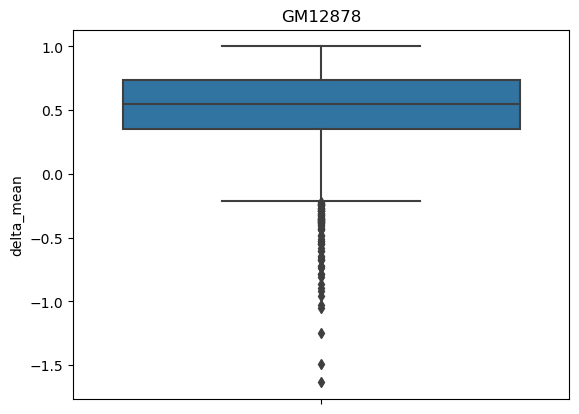

train valid 0.451119055620833
train test 0.2300802353204956
valid test 0.15973840153070684


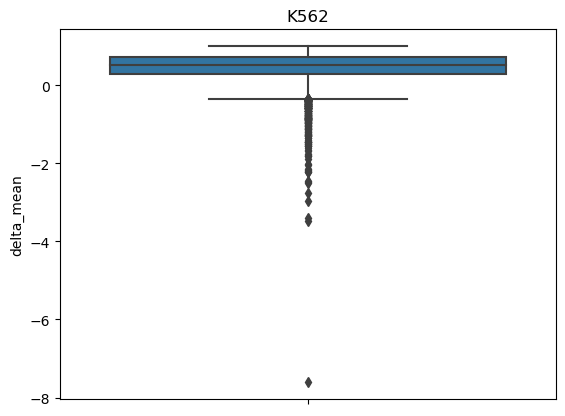

train valid 0.006124187119411338
train test 0.015924660907864395
valid test 0.6465444997867731


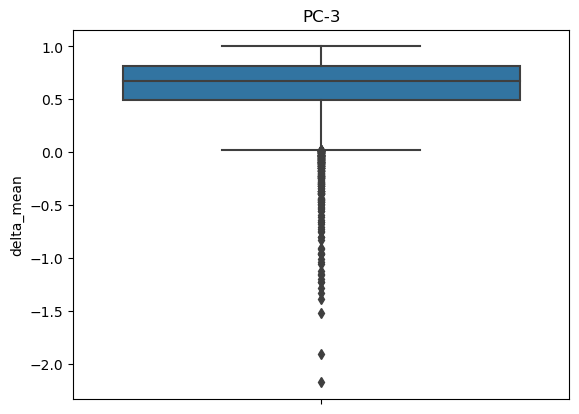

In [38]:
for cell, classified_seqs in classified_seq_cell.items():
    for pair in pairs:
        f1, f2 = pair
        a = classified_seqs[classified_seqs[x]==f1][y]
        b = classified_seqs[classified_seqs[x]==f2][y]
        stat, pvalue = scipy.stats.mannwhitneyu(a, b)
        print(f'{f1} {f2} {pvalue}')

    ax=sns.boxplot(data=classified_seqs, hue=x, y=y)
    plt.title(cell)
    plt.show()

In [26]:
classified_seqs

,Unnamed: 0,delta_mean,path_x,wt,std,mean_mut,seq_id,context,cell_line,path_y,fold
0,0,0.477846,../results//context_dependence_test_100/enform...,14.784366,2.222776,7.719713,XPO5_chr6_43576038_-.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
1,1,0.927049,../results//context_dependence_test_100/enform...,14.783938,0.652025,1.078504,UPK2_chr11_118956297_+.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
2,2,0.879795,../results//context_dependence_test_100/enform...,14.816709,1.007191,1.781050,PLEKHB1_chr11_73647625_+.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
3,3,-1.282113,../results//context_dependence_test_100/enform...,14.803543,6.064398,33.783363,ZNF606_chr19_58002819_-.pickle,silencing,PC-3,../results/context_dependence_test_100/enforme...,train
4,4,0.871365,../results//context_dependence_test_100/enform...,14.812580,1.361411,1.905413,SLC25A30_chr13_45418373_-.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
...,...,...,...,...,...,...,...,...,...,...,...
9339,9995,0.696849,../results//context_dependence_test_100/enform...,447.238680,36.277294,135.580690,CCT3_chr1_156338257_-.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
9340,9996,0.673640,../results//context_dependence_test_100/enform...,449.256040,28.989002,146.619230,MDH2_chr7_76048105_+.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
9341,9997,0.550541,../results//context_dependence_test_100/enform...,451.634580,31.148926,202.991270,HSP90B1_chr12_103930409_+.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
9342,9998,0.529612,../results//context_dependence_test_100/enform...,454.693760,20.745981,213.882630,ITGB1_chr10_32958230_-.pickle,other,PC-3,../results/context_dependence_test_100/enforme...,train
